In [ ]:
#@title ### Setup notebook.
!gdown 1DgOZ56YruuUmHRD7hZNJNM39mlbRGApp > /dev/null 2>&1 # sample metadata
!gdown 1Df7xqxCbENHB4oeovf2dYpx9_3dyYEYv > /dev/null 2>&1 # 16S_counts
!gdown 15SQ9C5r_ExRGTiX3zehu959lKW_LrrBp > /dev/null 2>&1 # bacteria_counts
!gdown 1yeBvAHeULU4Vk_TeAtWuF8kZRhyNCNa- > /dev/null 2>&1 # sequence_to_species_dict
!gdown --id 1R4Nv1SY4zn_Z3wnZuJcCHKI6yVPGGgGZ > /dev/null 2>&1 # bacteria counts lognorm


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

metadata = pd.read_table('sample_metadata.tsv')
metadata.index = ['farm_%i' %i for i in range(len(metadata))]

sequences_counts = pd.read_table('16S_counts.tsv')
sequences_counts.index = ['farm_%i' % i for i in range(len(sequences_counts))]

bacteria_counts = pd.read_table('bacteria_counts.tsv')
bacteria_counts.index = ['farm_%i' % i for i in range(len(bacteria_counts))]
cols = list(bacteria_counts.columns)
np.random.seed(42)
np.random.shuffle(cols)
bacteria_counts = bacteria_counts[cols]
sequence_to_species_dict = np.load('sequence_to_species_dict.npy', allow_pickle=True).item()

bacteria_counts = bacteria_counts.drop(['Unnamed: 0'], axis=1)
bacteria_counts_lognorm = pd.read_csv('bacteria_counts_lognorm.csv', index_col=0)
print("Setup successful.")

Setup successful.


In [ ]:
metadata.head()

,crop_yield,sample_type,country,timestamp
farm_0,0.68,barley soil sample,GAZ:Australia,2011-3-26
farm_1,1.00,barley soil sample,GAZ:Australia,2011-11-22
farm_2,0.87,barley soil sample,GAZ:Australia,2011-6-10
farm_3,0.68,barley soil sample,GAZ:Australia,2011-11-3
farm_4,0.67,barley soil sample,GAZ:Australia,2011-3-26


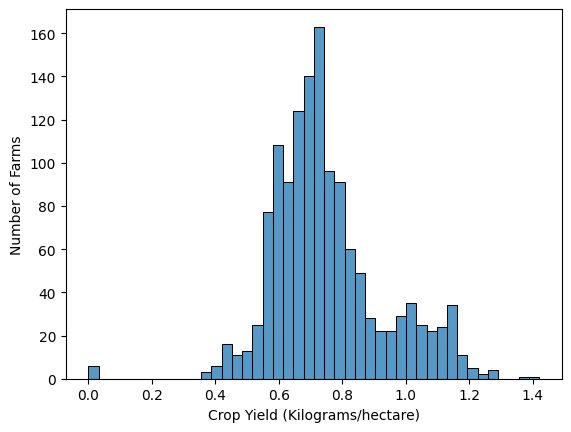

In [ ]:
ax = sns.histplot(data=metadata['crop_yield'])
ax.set(xlabel='Crop Yield (Kilograms/hectare)', ylabel='Number of Farms')
plt.show()

In [ ]:
bacteria_counts.head()

,Xanthomonadales,Glutamicibacter,Geobacillus,Rickettsia,Armatimonadales,Phaselicystis,Gammaproteobacteria,Candidatus Berkiella,Lawsonella,Hungateiclostridiaceae,...,Dyella,Proteobacteria,C0119,Vampirovibrionaceae,Abditibacterium,Arenimonas,Blastococcus,Haemophilus,Peptoclostridium,Beutenbergiaceae
farm_0,0.0,0.0,0.0,0.0,0.0,2.0,63.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
farm_1,156.0,0.0,0.0,0.0,0.0,77.0,236.0,10.0,0.0,0.0,...,0.0,0.0,32.0,0.0,15.0,17.0,94.0,0.0,0.0,0.0
farm_2,133.0,0.0,0.0,7.0,95.0,60.0,1164.0,13.0,0.0,4.0,...,0.0,0.0,66.0,0.0,9.0,16.0,14.0,0.0,0.0,0.0
farm_3,199.0,0.0,0.0,0.0,0.0,95.0,274.0,0.0,0.0,0.0,...,0.0,0.0,73.0,0.0,2.0,15.0,54.0,0.0,0.0,1.0
farm_4,0.0,0.0,0.0,0.0,0.0,0.0,2265.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
low_prev_bacteria = []
bacteria = bacteria_counts.columns
for b in bacteria:
  if sum(bacteria_counts[b]>0)<10:  # If bacteria 'b' is a singleton,

    # Fill in the code below to add bacteria 'b' to the list of singletons.
    low_prev_bacteria = low_prev_bacteria + [b]


# Fill in the code below to count the total number of singletons.
n_low_prevalence = len(low_prev_bacteria)
print('%i bacteria are low prevalence.' % n_low_prevalence)

# The 'drop' function drops the columns specified from the bacteria_counts dataframe.
bacteria_counts_no_low_prev = bacteria_counts.drop(low_prev_bacteria, axis=1)

29 bacteria are low prevalence.


In [ ]:
bacteria_counts_lognorm = np.log(bacteria_counts_no_low_prev + 1)

In [ ]:
bacteria_counts_lognorm.to_csv('bacteria_counts_lognorm.csv')

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


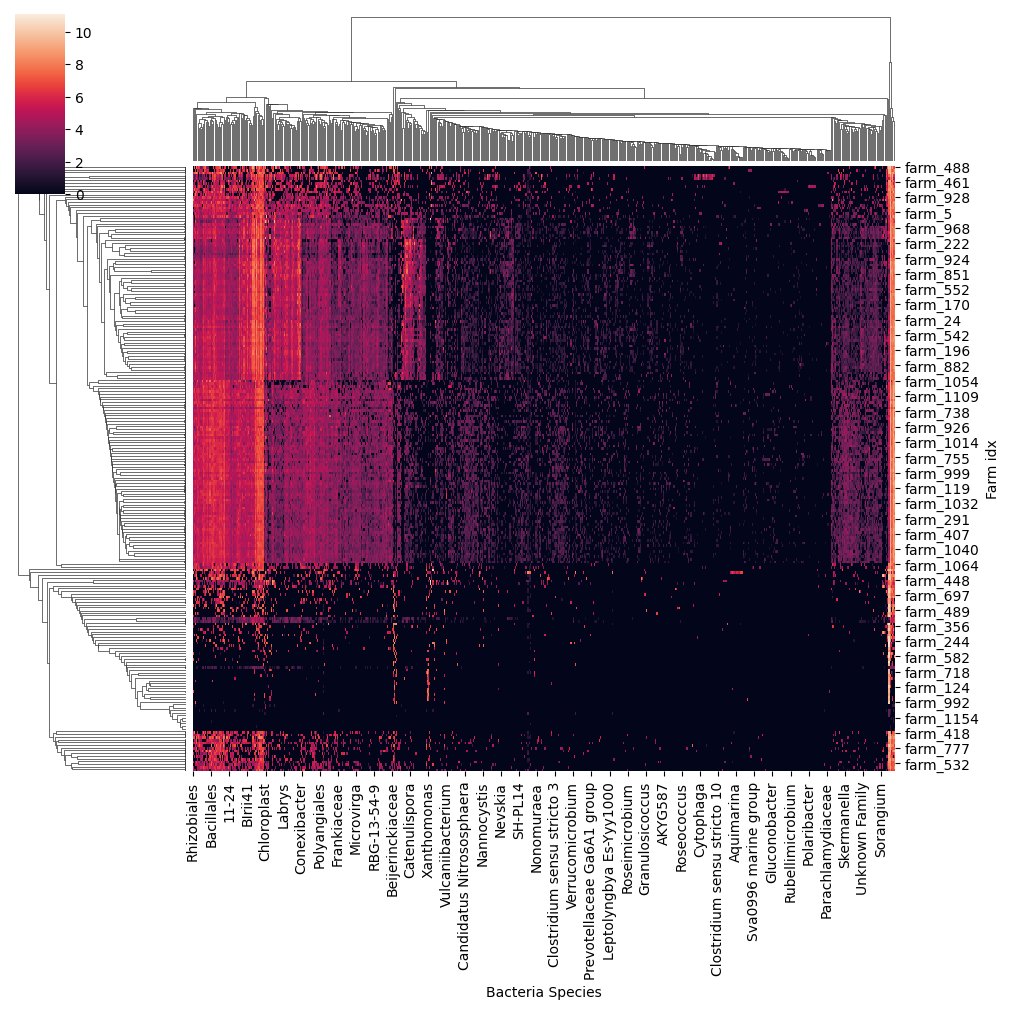

In [ ]:
f = sns.clustermap(bacteria_counts_lognorm)
f.ax_heatmap.set_ylabel('Farm idx')
f.ax_heatmap.set_xlabel('Bacteria Species')
plt.show()

In [ ]:
sequences_counts.head()

,TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTG,TACAGAGGGTGCGAGCGTTAATCGGATTTACTGGGCGTAAAGCGTGCGTAGGCGGCTTTTTAAGTCGGATGTGAAATCCCCGAGCTTAACTTGGGAATTG,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGCGCAGGCGGTTTTGTAAGTCAGATGTGAAAGCCCCGGGCTCAACCTGGGAACTG,TACGAAGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGACTCTTAAGTCGGGGGTGAAAGCCCAGGGCTCAACCCTGGAATTG,TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTTTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGT,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGCGCTTAACGTGGGAACTG,TACGTAGGGTGCTAGCGTTGTTCGGAATCATTGGGCGTAAAGCGCGTGTAGGCTGTCAATTAAGTCGGGTGTGAAAGCCCTCGGCTCAACCGAGGAAGTG,TACAGAGGGTGCAAGCGTTGTTCGGAATTATTGGGCGTAAAGCGCGTGTAGGCGGCTTTGCAAGTCGGGTGTGAAAGCCCTCAGCTCAACTGAGGAAGTG,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGTCCGTTGTGTCTGCGGTGAAATCCCCGGGCTTAACCTGGGAATGG,TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGACTGGAAAGTCAGAGGTGAAATCCCAGGGCTCAACCTTGGAACTG,...,TACGTAGGGTACAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGTGGTTGGTCACGTCTGCTGTGGAAACGCAACGCTTAACGTTGCGCGTG,TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTAGTTCAGCAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTG,TACGTAGGGGGCTAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCGTGTAGGCGGCCCGGTAAGTCCGCTGTGAAAGTCGGGGGCTCAATCCTCGAATGC,TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGTTCCTTAAGTCTGATGTGAAAGCCCGCGGCTCAACCGTGGAGGGT,GACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGCAGGCGGTTGTCCAAGTTGGATGTGAAAGCCTTGAGCTCAACTCAAGAAATG,TACGAAGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGTTTCCTAAGTCGGTGGTGAAATCCTGGAGCTCAACTCCAGAACTG,TACAGAGGTCCCAAGCGTTGTTCGGATTCACTGGGCGTAAAAGGTGCGTAGGTGGTGAGGTAAGTCGGATGTGAAAGCTCGGAGCTCAACTCCGAAATGG,GACGAACCGTGCGAACGTTGTTCGGAATCACTGGGCTTAAAGGTCGCGTAGGCGGGCTCGCAAGTCAGGGGTGAAATCCCACGGCTCAACCGTGGAAGTG,TACGTAGGGGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGCGTGTAGGCGGCCAGGTAGGTCTGCTGTGAAAACTCGAGGCTCAACCTCGAGACGT,GACGTAGGGGGCCAGCGTTGTTCGGAATTACTGGGTGTAAAGGGTTCGTAGGCGGTGTGGCAAGTCGGGAGTGAAATTTCTGGGCTTAACCCAGAACCTG
farm_0,2002.0,121.0,0.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
farm_1,143.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
farm_2,99.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
farm_3,205.0,0.0,0.0,0.0,0.0,0.0,0.0,235.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
farm_4,26858.0,0.0,0.0,1.0,31.0,525.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
bacteria_counts[bacteria_counts.columns[20::20]].head()

,Modestobacter,Citrifermentans,Azospirillaceae,Rhizobacter,Desulfovibrio,Lewinella,Inquilinus,Lactococcus,BIrii41,Haliangium,...,OLB14,Aliterella,Oligoflexus,Turneriella,11-24,Pseudonocardiaceae,Dechloromonas,Streptomycetaceae,Psychromonas,Dyella
farm_0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,171.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,286.0,0.0,0.0
farm_1,3.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,136.0,1141.0,...,0.0,0.0,0.0,0.0,137.0,85.0,4.0,34.0,0.0,0.0
farm_2,0.0,0.0,5.0,936.0,0.0,0.0,87.0,0.0,907.0,1027.0,...,0.0,0.0,0.0,40.0,98.0,27.0,0.0,20.0,0.0,0.0
farm_3,20.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,239.0,1064.0,...,0.0,0.0,0.0,0.0,254.0,48.0,0.0,26.0,0.0,0.0
farm_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# The groupby function works better when we are aggregating over columns,
# so we transpose our data.
sequences_counts_t = sequences_counts.transpose()

# Step 1: Create a new column called "species" that corrsponds to the species of a given barcode,
# per looked up in the dictionary.
sequences_counts_t['species'] = [sequence_to_species_dict[i] for i in sequences_counts_t.index]


# Step 2: Use the pandas "groupby" function to group sequences together by species.
# and Step 3: Use the .sum() function to sum together the counts of the grouped sequences.

summed_data = sequences_counts_t.groupby('species').sum()

# Finally, we will re-transpose the data so that our columns are bacteria and our rows are each farm.
bacteria_counts = summed_data.transpose()
bacteria_counts.head()

species,0319-6G20,0319-7L14,053A03-B-DI-P58,11-24,1174-901-12,1921-2,1959-1,27F-1492R,37-13,67-14,...,Yersiniaceae,bac2nit3,bacteriap25,cvE6,env.OPS 17,mle1-27,mle1-7,possible genus 04,uncultured,vadinHA49
farm_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,...,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,6422.0,2.0
farm_1,32.0,0.0,0.0,137.0,0.0,3.0,0.0,3.0,0.0,489.0,...,0.0,0.0,229.0,2.0,16.0,52.0,44.0,38.0,10988.0,66.0
farm_2,38.0,0.0,0.0,98.0,0.0,0.0,0.0,0.0,1.0,114.0,...,0.0,0.0,134.0,4.0,128.0,38.0,51.0,33.0,6860.0,43.0
farm_3,62.0,0.0,0.0,254.0,0.0,0.0,0.0,3.0,0.0,351.0,...,0.0,0.0,653.0,5.0,35.0,53.0,166.0,72.0,12701.0,64.0
farm_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8750.0,0.0


In [ ]:
print('Shape of sequence_counts:', np.shape(sequences_counts))
print('Shape of bacteria_counts:', np.shape(bacteria_counts))

Shape of sequence_counts: (1344, 8844)
Shape of bacteria_counts: (1344, 650)


In [ ]:
bacteria_counts

species,0319-6G20,0319-7L14,053A03-B-DI-P58,11-24,1174-901-12,1921-2,1959-1,27F-1492R,37-13,67-14,...,Yersiniaceae,bac2nit3,bacteriap25,cvE6,env.OPS 17,mle1-27,mle1-7,possible genus 04,uncultured,vadinHA49
farm_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,...,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,6422.0,2.0
farm_1,32.0,0.0,0.0,137.0,0.0,3.0,0.0,3.0,0.0,489.0,...,0.0,0.0,229.0,2.0,16.0,52.0,44.0,38.0,10988.0,66.0
farm_2,38.0,0.0,0.0,98.0,0.0,0.0,0.0,0.0,1.0,114.0,...,0.0,0.0,134.0,4.0,128.0,38.0,51.0,33.0,6860.0,43.0
farm_3,62.0,0.0,0.0,254.0,0.0,0.0,0.0,3.0,0.0,351.0,...,0.0,0.0,653.0,5.0,35.0,53.0,166.0,72.0,12701.0,64.0
farm_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8750.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
farm_1339,39.0,0.0,0.0,140.0,1.0,0.0,0.0,0.0,3.0,155.0,...,0.0,0.0,246.0,0.0,151.0,43.0,110.0,7.0,7733.0,30.0
farm_1340,22.0,0.0,0.0,181.0,17.0,0.0,0.0,4.0,0.0,260.0,...,0.0,0.0,317.0,0.0,37.0,9.0,139.0,0.0,8301.0,44.0
farm_1341,170.0,0.0,0.0,35.0,0.0,0.0,6.0,0.0,3.0,71.0,...,0.0,0.0,41.0,0.0,147.0,4.0,5.0,3.0,6589.0,36.0
farm_1342,53.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,15.0,133.0,...,0.0,0.0,86.0,4.0,510.0,72.0,45.0,3.0,10364.0,5.0


In [ ]:
X = bacteria_counts_lognorm
y = metadata['crop_yield']

# Next, split your data into testing and training.
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Now, initialize your model (just use the default settings for now!)
model = DecisionTreeRegressor()

# Train your model with the training data.
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
preds = model.predict(X_test)

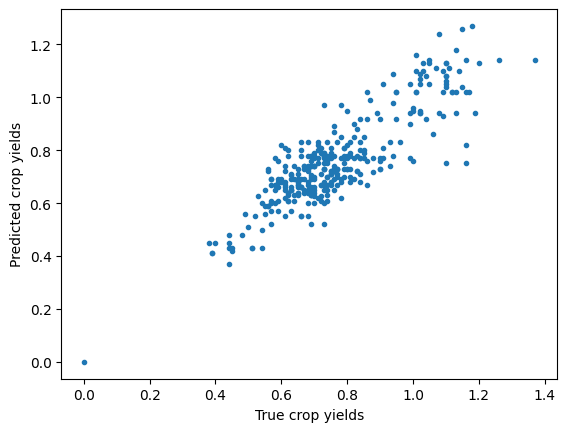

In [ ]:
plt.plot(y_test, preds, '.')
plt.xlabel('True crop yields')
plt.ylabel('Predicted crop yields')
plt.show()

In [ ]:
# Now, initialize your model (just use the default settings for now!)
small_model = DecisionTreeRegressor(max_depth=3, max_leaf_nodes=4)

# Train your model with the training data, using only three features.
small_model.fit(X_train[['Actinocorallia', 'Clostridium sensu stricto 10', 'Blastocatellaceae']], y_train)

DecisionTreeRegressor(max_depth=3, max_leaf_nodes=4)

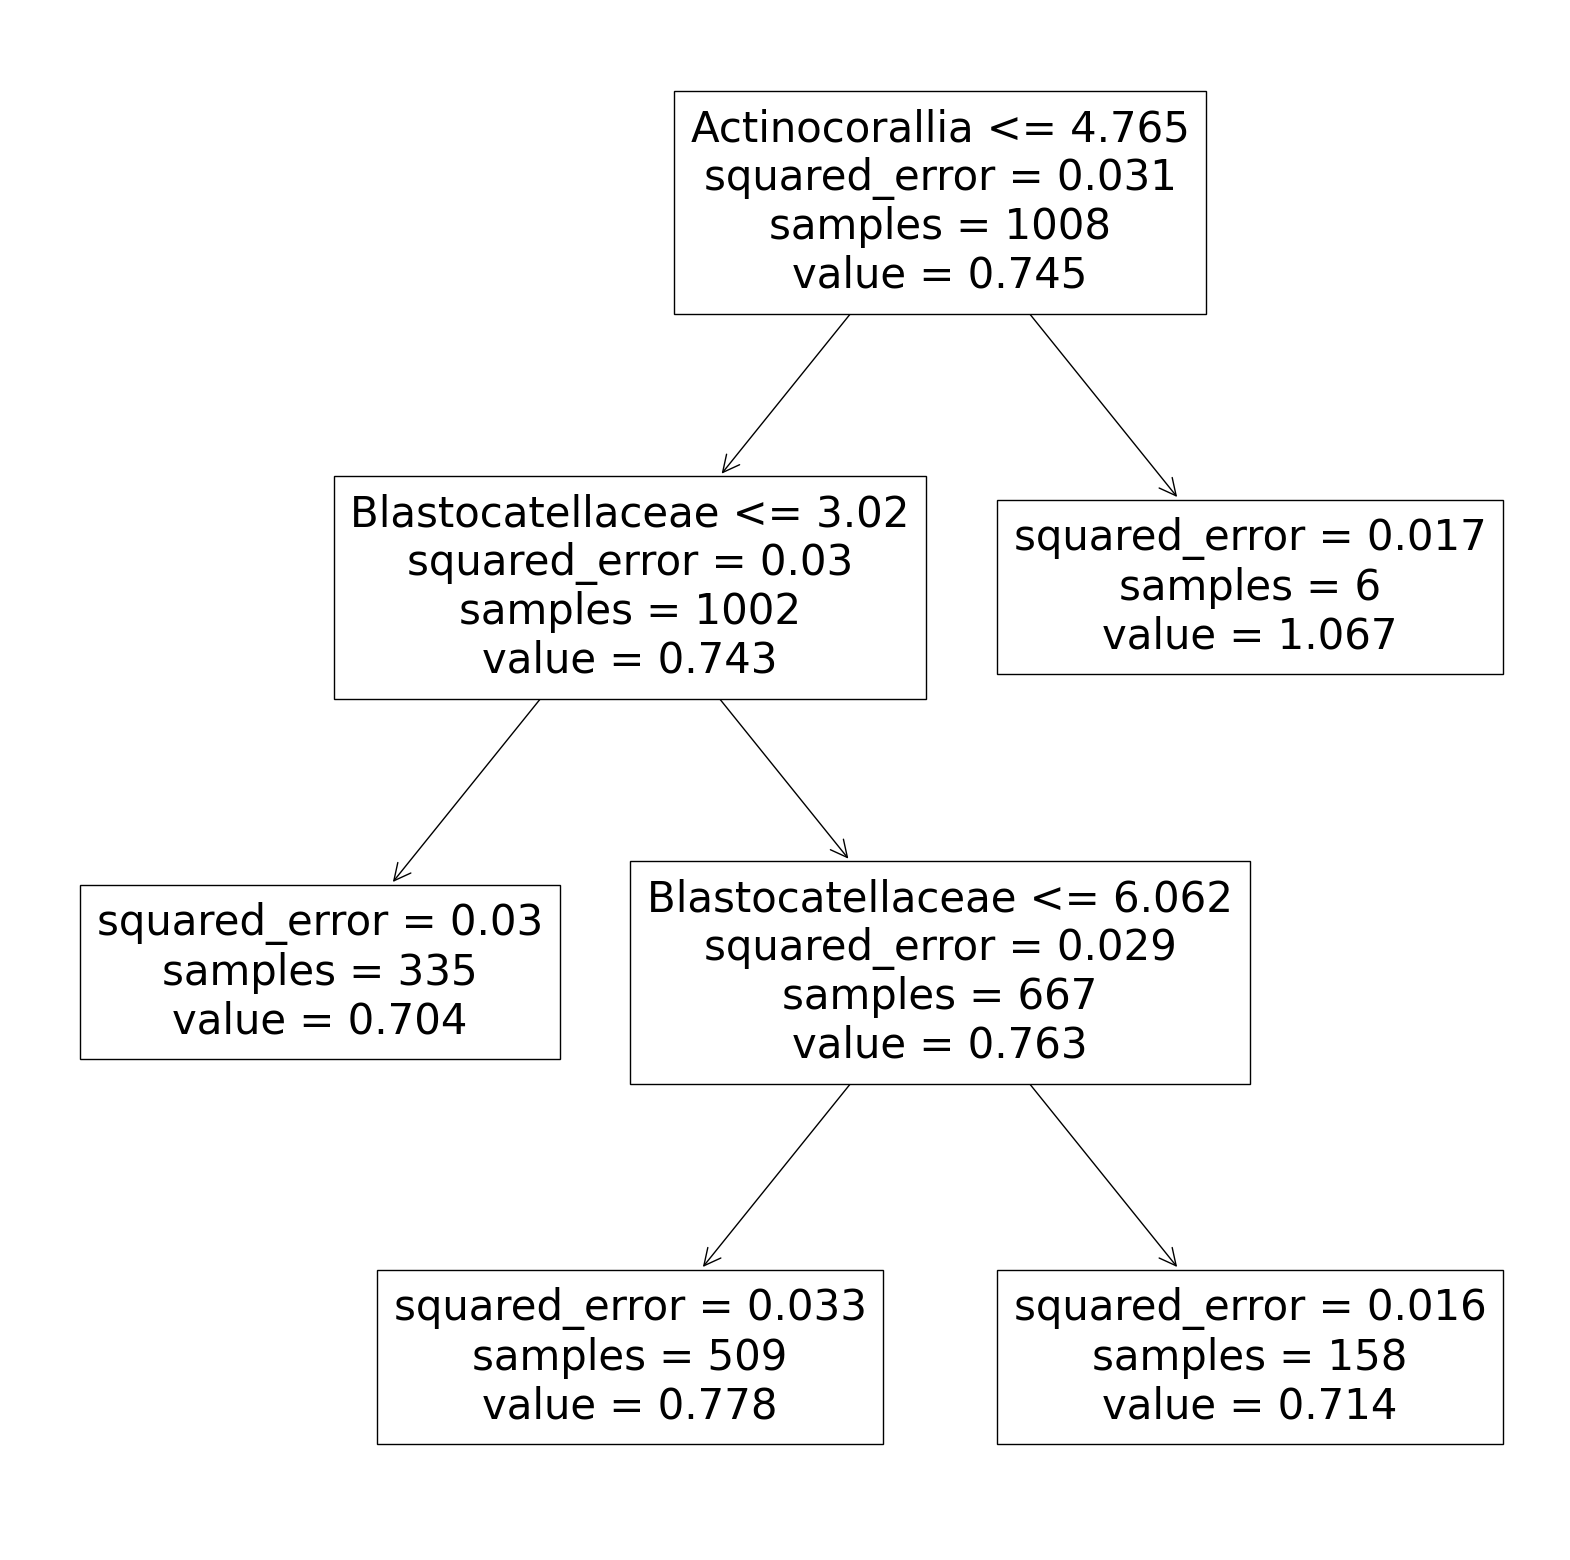

In [ ]:
plt.figure(figsize=(20,20))
plot_tree(small_model, feature_names=['Actinocorallia', 'Clostridium sensu stricto 10', 'Blastocatellaceae'])
plt.show()

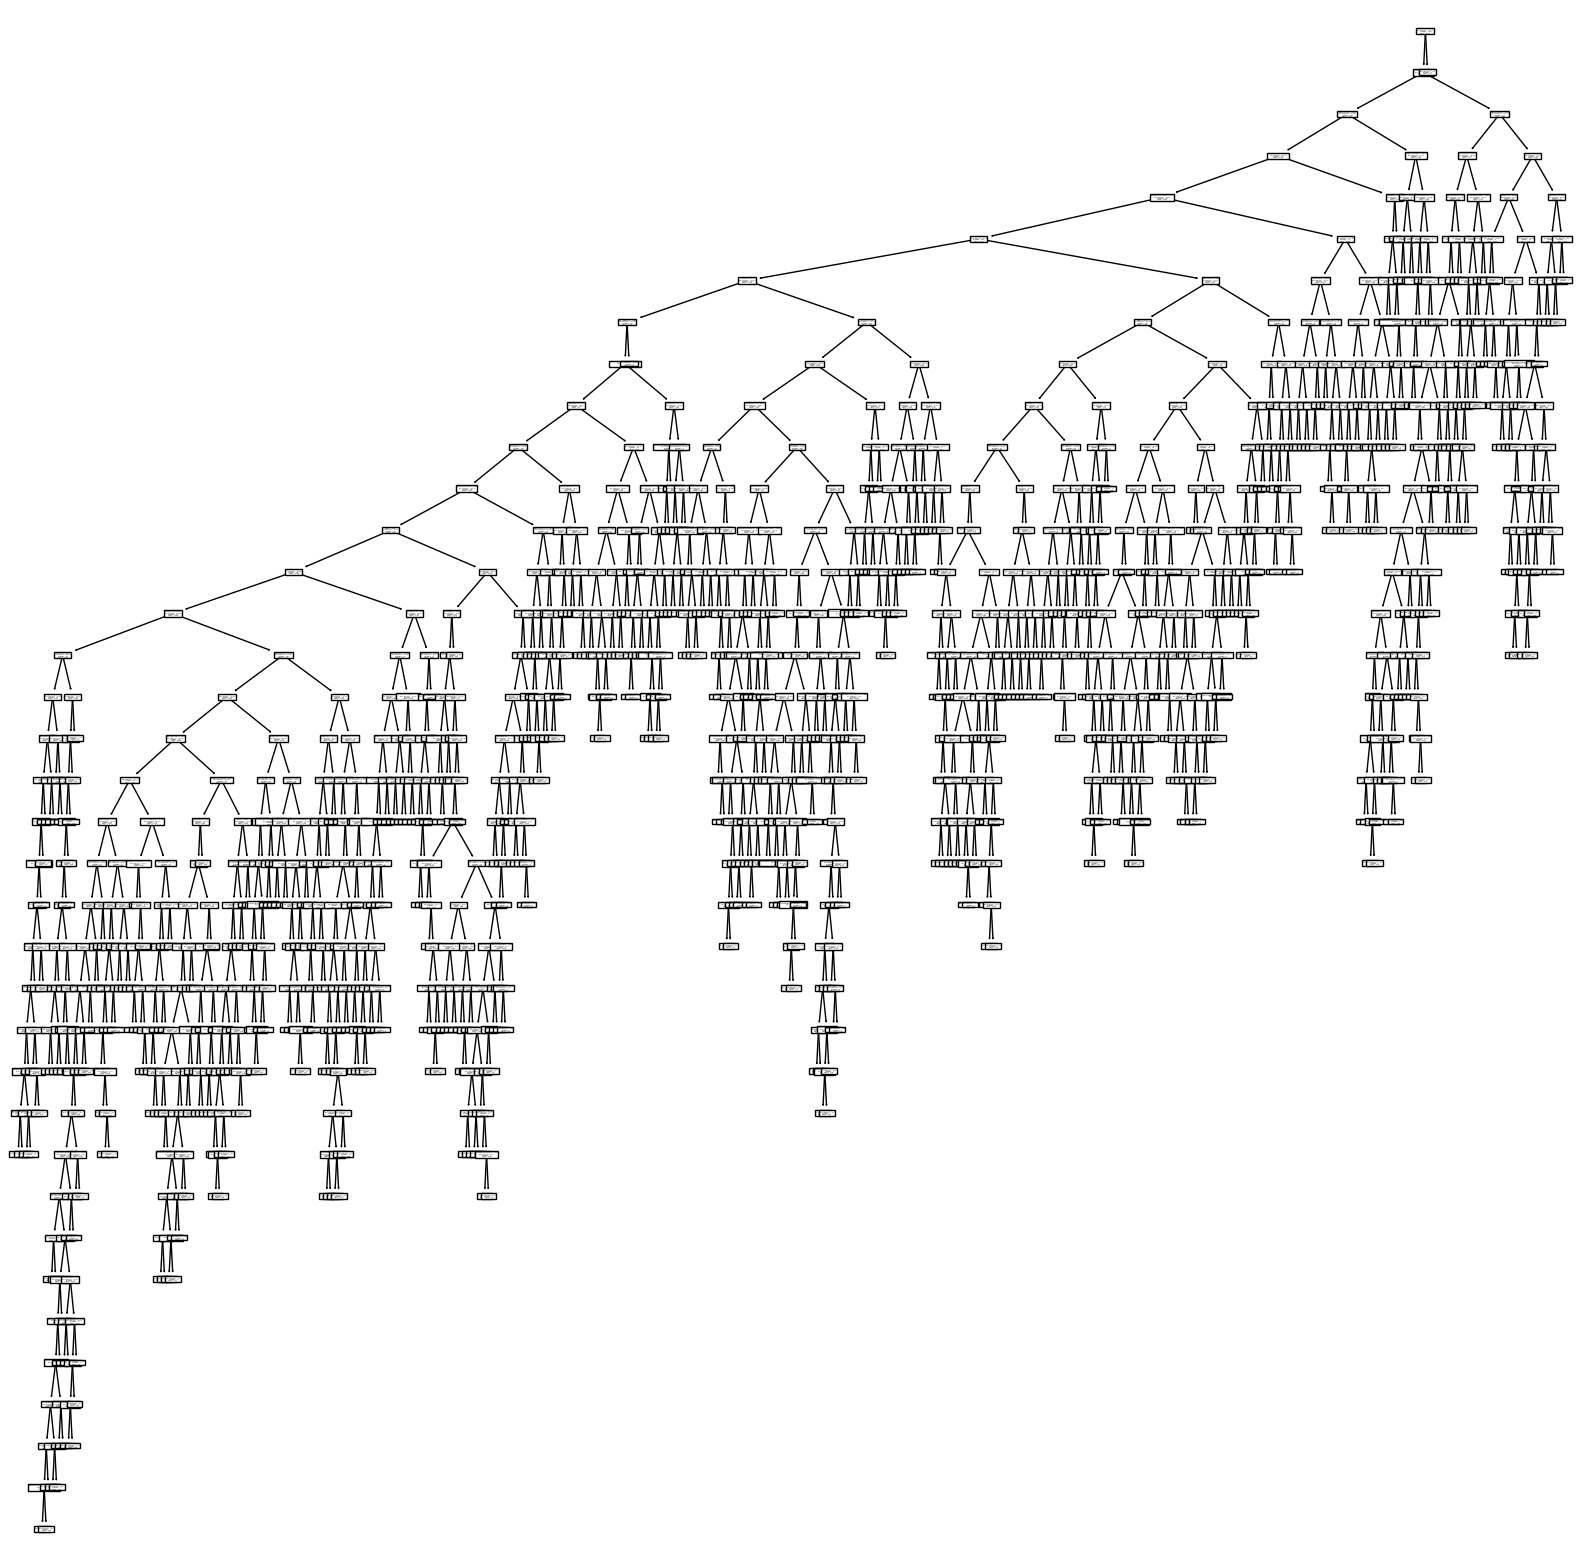

In [ ]:
plt.figure(figsize=(20,20))
plot_tree(model, feature_names=X.columns)
plt.show()

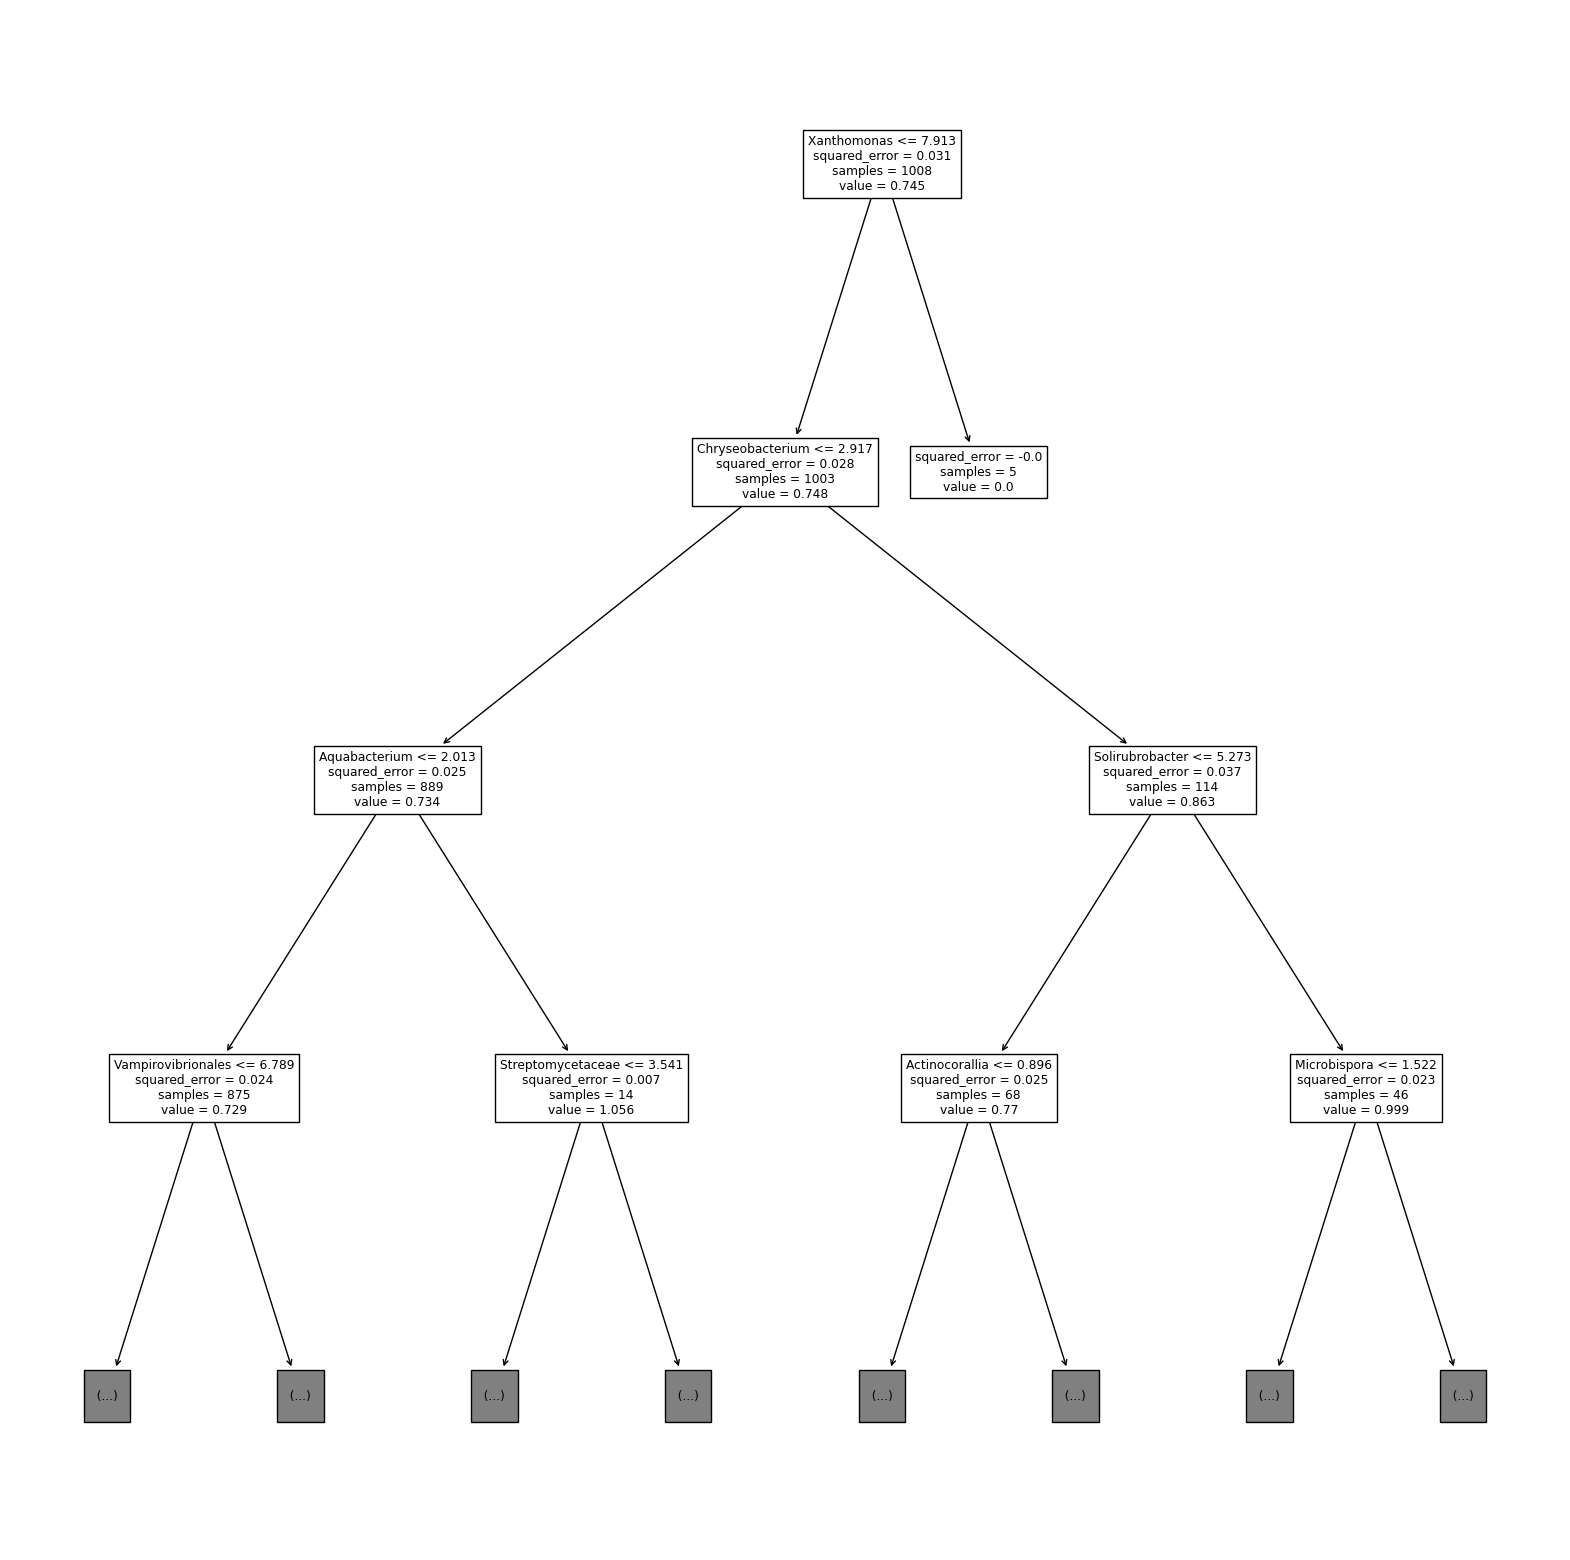

In [ ]:
plt.figure(figsize=(20,20))
plot_tree(model, max_depth=3, feature_names=X.columns)
plt.show()

In [ ]:
## Create a feature_importance dataframe.
feature_importance_dataframe = pd.DataFrame(model.feature_importances_, columns=['feature_importance'])
feature_importance_dataframe.index = X.columns
feature_importance_dataframe.head(10)

,feature_importance
Actinocorallia,0.034177
Clostridium sensu stricto 10,0.000000
Blastocatellaceae,0.015291
Saprospiraceae,0.000000
Frankiales,0.000002
Pedosphaeraceae,0.000837
possible genus 04,0.000000
S0134 terrestrial group,0.000000
Kaistia,0.000000
BIrii41,0.001316


In [ ]:
# Use the .sort_values() function to sort the rows of your dataframe.
feature_importance_dataframe_sorted = feature_importance_dataframe.sort_values('feature_importance', ascending=False)

#Use the .head() function to take a look at the top 5 most important features.
feature_importance_dataframe_sorted.head()

,feature_importance
Xanthomonas,0.091270
Chryseobacterium,0.054328
Aquabacterium,0.047918
Solirubrobacter,0.046616
Vampirovibrionales,0.046144


In [ ]:
# Now, initialize your model (just use the default settings for now!)
model = DecisionTreeRegressor(max_depth=100, max_leaf_nodes=200)

# Now, initialize your model (just use the default settings for now!)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=100, max_leaf_nodes=200)

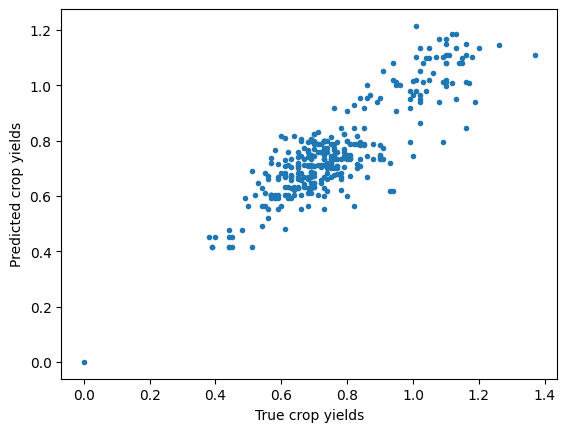

In [ ]:
# Make predictions on your test data. (Don't try to compute accuracy just yet...)
preds = model.predict(X_test)

# Plot your predictions against the true crop yields of the test data
plt.plot(y_test, preds, '.')
plt.xlabel('True crop yields')
plt.ylabel('Predicted crop yields')
plt.show()

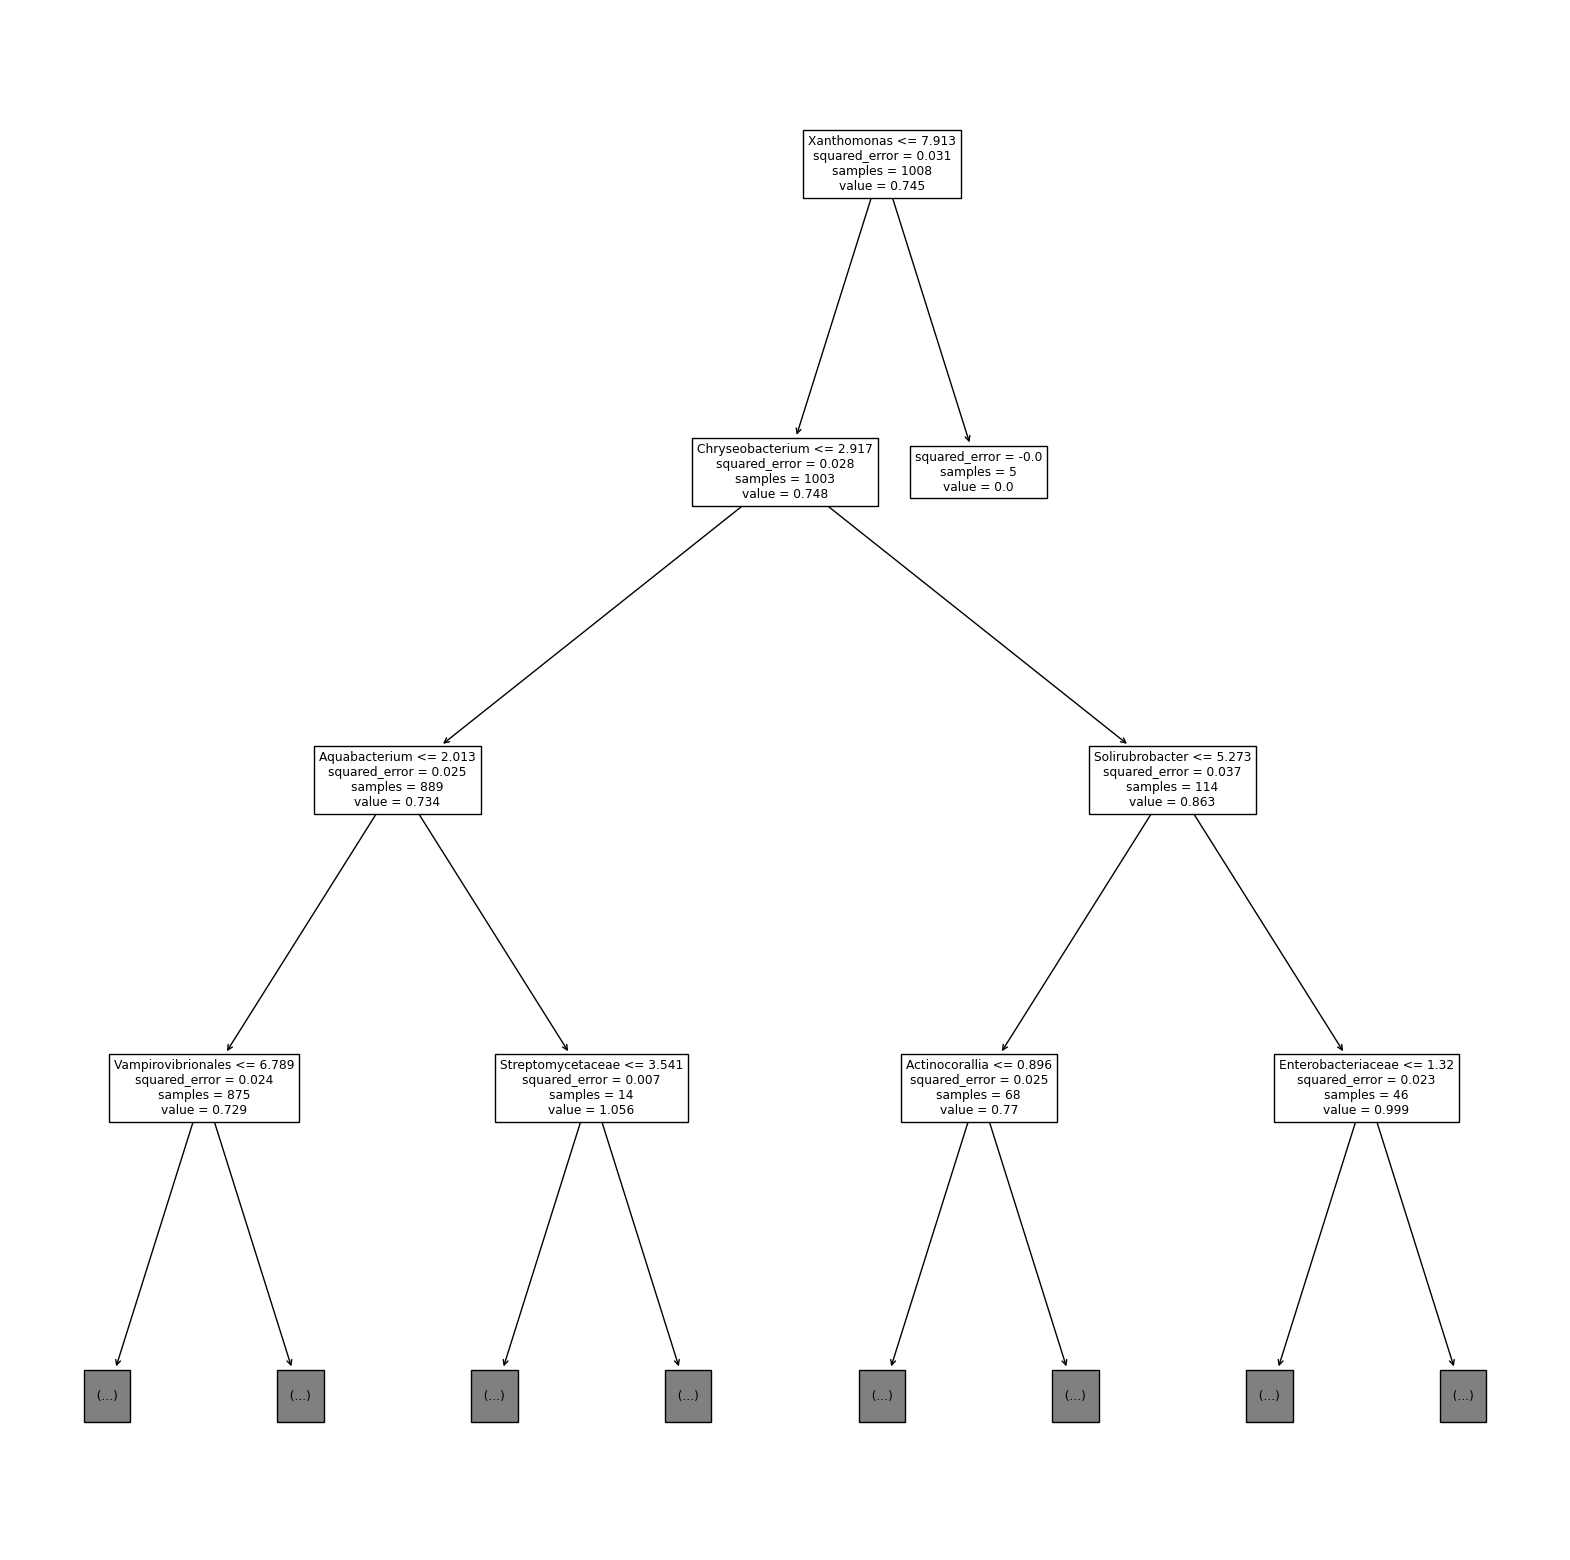

In [ ]:
plt.figure(figsize=(20,20))

# Use plot_tree to visualize the first few branches of your decision tree.
plot_tree(model, max_depth=3, feature_names=X.columns)
plt.show()

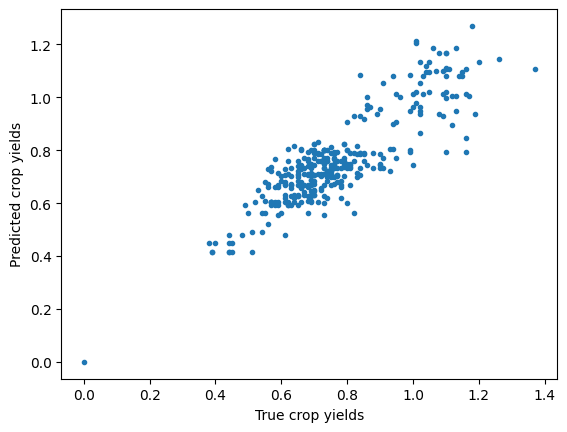

In [ ]:
# We helped you define your X and y data here.
X = bacteria_counts_lognorm
y = metadata['crop_yield']

# Split your data into testing and training.
X_train_dtr, X_test_dtr, y_train_dtr, y_test_dtr = train_test_split(X, y)

# Now, initialize your model (just use the default settings for now!)
decision_tree_regressor = DecisionTreeRegressor(max_depth=100, max_leaf_nodes=200)

# Now, initialize your model (just use the default settings for now!)
decision_tree_regressor.fit(X_train_dtr, y_train_dtr)

# Make predictions on your test data. (Don't try to compute accuracy just yet...)
preds_dtr = decision_tree_regressor.predict(X_test_dtr)

# Plot your predictions against the true crop yields of the test data

plt.plot(y_test_dtr, preds_dtr, '.')
plt.xlabel('True crop yields')
plt.ylabel('Predicted crop yields')
plt.show()

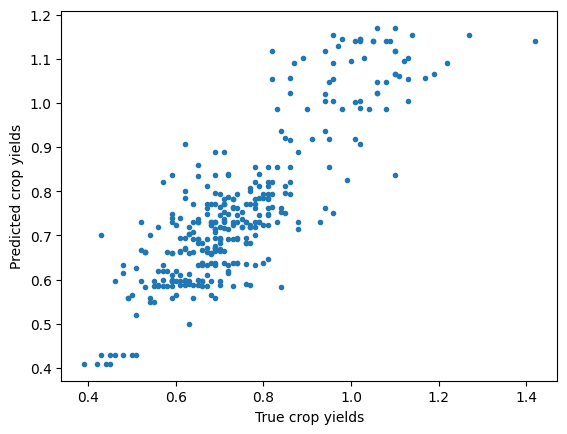

In [ ]:
# We helped you define your X and y data here.
X = bacteria_counts_lognorm
y = metadata['crop_yield']

# Split your data into testing and training.
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Now, initialize your model (just use the default settings for now!)
model = DecisionTreeRegressor(max_depth=100, max_leaf_nodes=200)

# Now, initialize your model (just use the default settings for now!)
model.fit(X_train, y_train)

# Make predictions on your test data. (Don't try to compute accuracy just yet...)
preds = model.predict(X_test)

# Plot your predictions against the true crop yields of the test data
plt.plot(y_test, preds, '.')
plt.xlabel('True crop yields')
plt.ylabel('Predicted crop yields')
plt.show()

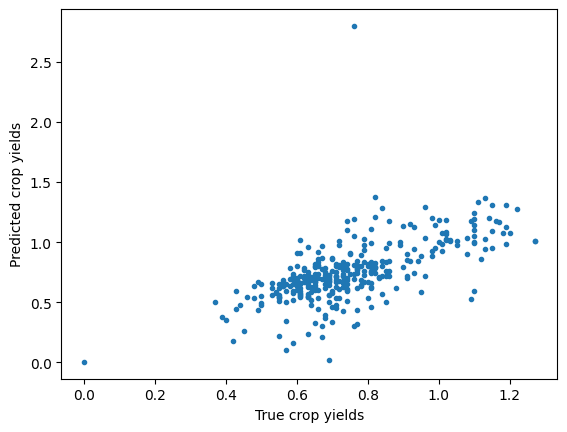

In [ ]:
# We helped you define your X and y data here.
X = bacteria_counts_lognorm
y = metadata['crop_yield']

# Split your data into testing and training.
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Now, initialize your model (just use the default settings for now!)
model = LinearRegression()

# Now, initialize your model (just use the default settings for now!)
model.fit(X_train, y_train)

# Make predictions on your test data. (Don't try to compute accuracy just yet...)
preds = model.predict(X_test)

# Plot your predictions against the true crop yields of the test data
plt.plot(y_test, preds, '.')
plt.xlabel('True crop yields')
plt.ylabel('Predicted crop yields')
plt.show()

In [ ]:
R2 = r2_score(y_test, preds)
print('R2=', R2)

R2= -0.199736307324621


In [ ]:
# Compute MAE using y_test and preds.
MAE = mean_absolute_error(y_test, preds)
print('MAE=', MAE)

MAE= 0.12675418917337997


In [ ]:
# Compute RSE using y_test and preds.
def relative_squared_error(true_vals, pred_vals):

  # Compute the total squared error for our predictions.
  total_squared_error = sum((pred_vals-true_vals)**2)

  # Compute the average of true_vals.
  average_of_true_vals = np.mean(true_vals)

  # Compute the total squared error if we were using a simple model.
  total_squared_error_simple_predictor  = sum((average_of_true_vals-true_vals)**2)

  # Return the ratio of total squared errors for our model compared to the simple model.
  return (total_squared_error/total_squared_error_simple_predictor)


# Use your newly defined function to compute the relative squared error using y_test and preds.
RSE = relative_squared_error(y_test, preds)
print('RSE=', RSE)

RSE= 1.19973630732462


In [ ]:
metadata

,crop_yield,sample_type,country,timestamp
farm_0,0.68,barley soil sample,GAZ:Australia,2011-3-26
farm_1,1.00,barley soil sample,GAZ:Australia,2011-11-22
farm_2,0.87,barley soil sample,GAZ:Australia,2011-6-10
farm_3,0.68,barley soil sample,GAZ:Australia,2011-11-3
farm_4,0.67,barley soil sample,GAZ:Australia,2011-3-26
...,...,...,...,...
farm_1339,0.74,barley soil sample,GAZ:Australia,2011-3-9
farm_1340,0.77,barley soil sample,GAZ:Australia,2011-9-25
farm_1341,0.69,barley soil sample,GAZ:Australia,2011-2-13
farm_1342,0.44,barley soil sample,GAZ:Australia,2011-1-2


In [ ]:
# Just to practice *again*, fill this in to make crop yield predictions
# on your training data. You can use whatever model you trained most recently.
crop_yield_test_predictions = model.predict(X_test) ### FILL IN ####

yield_predictions_dataframe = pd.DataFrame(data={'farm':X_test.index, 'crop_yield':crop_yield_test_predictions})
yield_predictions_dataframe.head()

,farm,crop_yield
0,farm_1301,0.629172
1,farm_1279,0.774699
2,farm_1292,1.243521
3,farm_953,0.594743
4,farm_1052,0.719287


In [ ]:
# Sort your predictions dataframe (in variable called yield_predictions_dataframe) by crop yield, and look at the top 10 farms.
# Hint: You can use .sort_values('yield_prediction', ascending=False) on the yield_predictions_dataframe variable.
sorted_dataframe = yield_predictions_dataframe.sort_values('crop_yield', ascending=False) # FILL IN ####

# Take the top 10 farms using .head().
top_farms_dataframe = sorted_dataframe.head(10)
farm_names=top_farms_dataframe['farm']
print("According to our model, the top 10 best plots are:", farm_names.to_list())
top_farms_dataframe

According to our model, the top 10 best plots are: ['farm_710', 'farm_639', 'farm_538', 'farm_585', 'farm_13', 'farm_889', 'farm_917', 'farm_791', 'farm_1073', 'farm_1292']


,farm,crop_yield
51,farm_710,2.800719
147,farm_639,1.374416
15,farm_538,1.366570
250,farm_585,1.336888
33,farm_13,1.312459
285,farm_889,1.309433
281,farm_917,1.293203
136,farm_791,1.280280
72,farm_1073,1.273684
2,farm_1292,1.243521


In [ ]:
# This extracts the true crop yields from the 10 farms the model suggested.
# crop_yields_top_10_predictions is thus an array of crop yields with length 10.
crop_yields_top_10_predictions = top_farms_dataframe['crop_yield']


# Fil in the line below to compute the total crop yield from all 10 farms combined.
total_crop_yield_using_model = sum(crop_yields_top_10_predictions)
print("total crop yield using model suggestions: ", total_crop_yield_using_model)

total crop yield using model suggestions:  14.591173304075138


In [ ]:
np.random.seed(42) # Change this to pick a different set of randomly chosen

# Fill in the code below to randomly pick 10 farms/crop yields from your test
# data. crop_yields_10_random_picks should then be an array of crop yields with
# length 10.

crop_yields_10_random_picks = np.random.choice(y_test, 10)## FILL ME IN ####)

# Fil in the line below to compute the total crop yield from
# all 10 randomly chosen farms combined.
total_crop_yield_using_lottery = sum(crop_yields_10_random_picks)
print("total crop yield using random picks: ", total_crop_yield_using_lottery)

total crop yield using random picks:  7.8


In [ ]:
# Fill in the code below to randomly pick 10 farms/crop yields from your test
# data. crop_yields_10_random_picks should then be an array of crop yields with
# length 10.
total_crop_yield_using_lottery_list = np.array([])
for _ in range(100): #### Fill this in with the syntax for a 'for' loop!

  crop_yields_10_random_picks =np.random.choice(y_test, 10)
  total_crop_yield_using_lottery =sum(crop_yields_10_random_picks)

  # Fill in the value you want to append to your list of total crop yields.
  total_crop_yield_using_lottery_list = np.append(total_crop_yield_using_lottery_list, total_crop_yield_using_lottery)
print('lottery crop yields: ', total_crop_yield_using_lottery_list)

lottery crop yields:  [7.86 7.82 8.64 8.21 7.13 7.27 6.93 6.42 7.9  8.45 6.54 7.43 7.57 7.21
 8.07 7.62 7.19 8.39 7.02 7.27 6.49 7.93 7.58 7.18 7.85 7.45 7.9  7.41
 8.15 7.29 7.21 7.4  8.2  7.14 7.95 7.36 7.26 6.95 8.63 6.79 8.36 7.42
 7.27 7.82 7.77 7.15 6.89 7.52 6.67 7.57 7.43 9.   6.76 7.2  6.08 7.89
 7.35 6.62 7.47 6.92 7.78 7.1  7.1  7.32 7.87 7.18 7.32 7.21 7.82 7.8
 7.32 7.8  6.97 7.59 7.62 8.04 7.58 7.94 7.12 8.11 8.13 6.83 8.08 7.07
 7.8  7.5  6.83 8.12 7.25 9.22 7.48 7.23 7.87 7.73 7.74 6.91 7.93 7.05
 7.43 8.06]


In [ ]:
# Fill in the code below to randomly pick 10 farms/crop yields from your test
# data. crop_yields_10_random_picks should then be an array of crop yields with
# length 10.
avg_total_crop_yield_from_lottery = np.mean(total_crop_yield_using_lottery_list)
print("average crop yield using lottery system:", avg_total_crop_yield_from_lottery)

average crop yield using lottery system: 7.510699999999998


Dotted line represents total crop yield if using model to select farms.


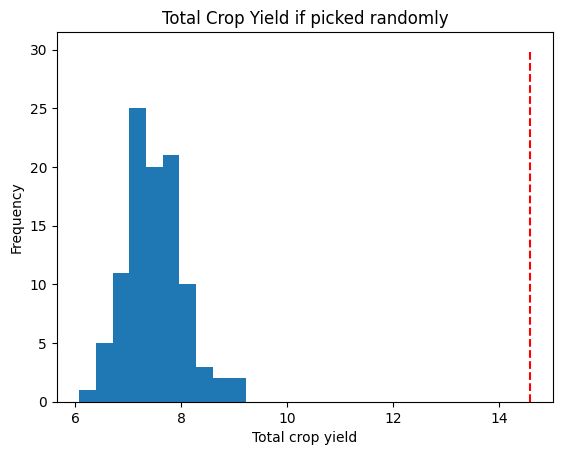

In [ ]:
plt.hist(total_crop_yield_using_lottery_list)
plt.vlines(total_crop_yield_using_model, ymin=0, ymax=30, color='r', linestyle='dashed')
plt.xlabel('Total crop yield')
plt.ylabel('Frequency')
plt.title('Total Crop Yield if picked randomly')
print('Dotted line represents total crop yield if using model to select farms.')

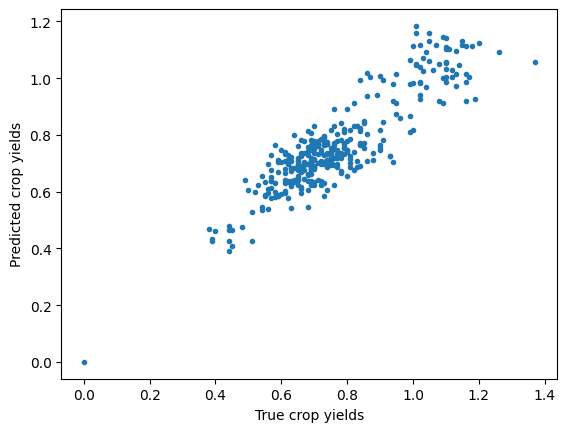

r2_score: 0.8039369046887321


In [ ]:
# We helped you define your X and y data here.
X = bacteria_counts_lognorm
y = metadata['crop_yield']

# Split your data into testing and training.
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Now, initialize your model (just use the default settings for now!)
model = RandomForestRegressor(n_estimators=10)

# Now, initialize your model (just use the default settings for now!)
model.fit(X_train, y_train)

# Make predictions on your test data. (Don't try to compute accuracy just yet...)
preds = model.predict(X_test)

# Plot your predictions against the true crop yields of the test data
plt.plot(y_test, preds, '.')
plt.xlabel('True crop yields')
plt.ylabel('Predicted crop yields')
plt.show()

print('r2_score:', r2_score(y_test, preds))

In [ ]:
feature_importances = model.feature_importances_
n_possible_features = len(feature_importances)
n_features_used = sum(feature_importances!=0)
print("The random forest model used %i out of a possible %i features" %
      (n_features_used, n_possible_features))

The random forest model used 500 out of a possible 632 features


In [ ]:
# Predict on the training data.
y_pred_train = model.predict(X_train)
training_r2 = r2_score(y_train, y_pred_train)

# Predict on the testing data.
y_pred_test = model.predict(X_test)
# Compare the predictions on the training data against the true crop yields.
testing_r2 = r2_score(y_test, y_pred_test)

print("Training r2: %", training_r2)
print("Testing r2: %", testing_r2)

Training r2: % 0.9583821729372152
Testing r2: % 0.8039369046887321


In [ ]:
model = RandomForestRegressor(n_estimators=10)

# Pass model to GridSearchCV as well as the values of ccp_alpha you wish to try out.
model_cv = GridSearchCV(model, param_grid={'ccp_alpha': [.00001, .00002, .00003, .00004, .00005]})


model_cv.fit(X_train, y_train)
print("Pruned Model Training R2:", r2_score(y_train,model_cv.predict(X_train)))
print("Pruned Model Testing R2:", r2_score(y_test,model_cv.predict(X_test)))
print("Best value of ccp_alpha:", model_cv.best_estimator_.ccp_alpha)
print("Number of non-zero feature importances in best model:", sum( model_cv.best_estimator_.feature_importances_!=0))

Pruned Model Training R2: 0.9386322721908805
Pruned Model Testing R2: 0.8135646079734884
Best value of ccp_alpha: 1e-05
Number of non-zero feature importances in best model: 364
